In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from tqdm import tqdm

### Save Data as Arrays

In [7]:
root="/mnt/ssd/ronak/datasets/cifar10"
download = True
train_data = CIFAR10(root, download=download)
test_data = CIFAR10(root, train=False, download=download)

x_train = train_data.data
x_test = test_data.data
y_train = np.array(train_data.targets)
y_test = np.array(test_data.targets)

100%|██████████| 170498071/170498071 [00:04<00:00, 34431410.76it/s]


Extracting /mnt/ssd/ronak/datasets/cifar10/cifar-10-python.tar.gz to /mnt/ssd/ronak/datasets/cifar10
Files already downloaded and verified


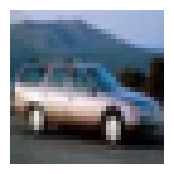

In [8]:
# check images
image = x_train[4]

# plt.axis("off")
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(image)
plt.show()

In [9]:
save_dir = "/mnt/ssd/ronak/datasets/cifar10"

np.save(os.path.join(save_dir, "x_train"), x_train)
np.save(os.path.join(save_dir, "y_train"), y_train)
np.save(os.path.join(save_dir, "x_test"),  x_test)
np.save(os.path.join(save_dir, "y_test"),  y_test)

### Create Random Quantization

In [10]:
from sklearn.cluster import KMeans

In [11]:
root = "/mnt/ssd/ronak/datasets/cifar10"

x_train = np.load(os.path.join(root, "x_train.npy"))
y_train = np.load(os.path.join(root, "y_train.npy"))
x_test  = np.load(os.path.join(root, "x_test.npy"))
y_test  = np.load(os.path.join(root, "y_test.npy"))

In [6]:
n_bins = 8

In [12]:
def quantize(n_bins=8):
    # for labels, they are already quantized
    suffix = f"_quantized_{n_bins}.npy"
    np.save(os.path.join(root, "y_train" + suffix), y_train)
    np.save(os.path.join(root, "y_test" + suffix), y_test)

    kmeans = KMeans(n_clusters=n_bins, random_state=0, n_init="auto").fit(x_train.reshape(len(x_train), -1))

    cx_train = kmeans.predict(x_train.reshape(len(x_train), -1))
    cx_test  = kmeans.predict(x_test.reshape(len(x_test), -1))

    np.save(os.path.join(root, "x_train" + suffix), cx_train)
    np.save(os.path.join(root, "x_test" + suffix), cx_test)

In [14]:
for b in tqdm([8, 16, 32, 40, 48, 64]):
    quantize(n_bins=b)

100%|██████████| 6/6 [01:25<00:00, 14.28s/it]


In [15]:
def simulate_probably(objects, k, b, s=1000):
    np.random.seed(123)
    count = 0
    for _ in range(s):
        batch = np.random.choice(objects, size=(b,), replace=False)
        count += int(len(np.unique(batch)) == k)
    return count / s

In [16]:
batch_size = 512

for k in [8, 16, 32, 40, 48, 64]:
    objects = np.load(os.path.join(root, f"x_train_quantized_{k}.npy"))
    print(f"{k}: {simulate_probably(objects, k, batch_size):0.4f}")


8: 1.0000
16: 1.0000
32: 1.0000
40: 0.9950
48: 0.9840
64: 0.0040


In [2]:
root = "/mnt/ssd/ronak/datasets/cifar10"
# for n_bins in [8, 16, 32, 40, 48, 64]:

n_bins = 40

cx_train = np.load(os.path.join(root, f"x_train_quantized_{n_bins}.npy"))
cy_train = np.load(os.path.join(root, f"y_train_quantized_{n_bins}.npy"))

ind, count = np.unique(cx_train, return_counts=True)
px = count / len(cx_train)

ind, count = np.unique(cy_train, return_counts=True)
py = count / len(cy_train)

In [3]:
np.save(os.path.join(root, "x_marginal.npy"), px)
np.save(os.path.join(root, "y_marginal.npy"), py)